## Klasifikacija radnih mesta<a id="par:nasl"></a>

U svesci je razmotrena primena tehnika obrade prirodnih jezika (*natural language processing*, *NLP*) na rešavanje problema razvrstavanja radnih mesta ([*job title*](https://en.wikipedia.org/wiki/International_Standard_Classification_of_Occupations)) prema senioritetu. Dostavljeni podaci su učitani i pripremljeni (normalizovani i vektorizovani) na više različitih načina, nakon čega je na delu radnih mesta obučeno nekoliko klasifikacionih modela. Modeli su vrednovani prema ponašanju na drugom delu podataka, odnosno uspešnosti predviđanja senioriteta.

<img src="../slike/nlp.png" alt="Ilustracija obrade prirodnih jezika" width="25%"/>

Pored samog koda i rezultata, usput su detaljno prokomentarisani svi preduzeti koraci. Posebno je zanimljivo napomenuti da je primenjeno ponešto karakteristično za svaku od tri faze razvoja obrade prirodnih jezika kao oblasti: simbolički *NLP* (regularni izrazi, klasifikacija prema ručno osmišljenim pravilima i slično), statistički *NLP* (metode mašinskog učenja), neuronski/duboki *NLP* (primena neuronskih mreža i dubokog učenja). Na slici je predstavljena složena veza [obrade prirodnih jezika](https://en.wikipedia.org/wiki/Natural_language_processing) (*NLP*) sa srodnim oblastima [mašinskog](https://en.wikipedia.org/wiki/Machine_learning) (*ML*) i posebno [dubokog učenja](https://en.wikipedia.org/wiki/Deep_learning) (*DL*), kao i šire oblasti [veštačke inteligencije](https://en.wikipedia.org/wiki/Artificial_intelligence) (*AI*). Kao glavna literatura korišćeno je treće izdanje poznate knjige [*Speech and Language Processing*](https://web.stanford.edu/~jurafsky/slp3/) (*SLP*), kao i detaljna dokumentacija biblioteke [*sklearn*](https://scikit-learn.org/stable/user_guide.html).

## Sadržaj [⮭]<a id="par:toc"></a>

[⮭]: #par:nasl

1. [Priprema teksta](#par:prip)  
    1.1 [Učitavanje podataka](#par:uchit)  
    1.2 [Analiza i čišćenje](#par:anchi)  
    1.3 [Normalizacija teksta](#par:norm)
2. [Vektorizacija teksta](#par:vekt)  
    2.1 [Klasifikaciona pravila](#par:prav)  
    2.2 [Retke reprezentacije](#par:retk)  
    2.3 [Guste reprezentacije](#par:gust)
3. [Klasifikacija teksta](#par:klas)  
    3.1 [Višelabelarna klasifikacija](#par:multi)  
    3.2 [Bajesovski klasifikator](#par:bajes)  
    3.3 [Logistička regresija](#par:logit)  
    3.4 [Metod potpornih vektora](#par:svm)  
    3.5 [Algoritam najbližih suseda](#par:knn)
4. [Analiza rezultata](#par:rezul)  
    4.1 [Matrica konfuzije](#par:konf)  
    4.2 [Mere uspešnosti](#par:mere)  
    4.3 [Skor klasfikatora](#par:skor)

## 1. Priprema teksta [⮭]<a id="par:prip"></a>

[⮭]: #par:toc

Prvi korak u rešavanju svakog problema obrade podataka jeste njihova priprema. Za početak, neophodno ih je učitati iz dostavljenih datoteka. Zatim ih je korisno analizirati i očistiti. Naposletku, važno ih je svesti na neki normalizovani oblik, kako bi se moglo pristupiti naprednijoj obradi poput klasifikacije.

### 1.1 Učitavanje podataka [⮭]<a id="par:uchit"></a>

[⮭]: #par:prip

Podaci se nalaze u pet različitih datoteka, od kojih su prve četiri (`20.txt`, `20-40.txt`, `40-60.txt`, `60-100.txt`) planirane za pravljenje i evaluaciju modela, dok peta (`test_titles.json`) sadrži neobeležena radna mesta i namenjena je proveri klasifikacije potpuno novih, nekategorizovanih i nezavisnih podataka. Sve nabrojane datoteke smeštene su u direktorijum `podaci`, koji nije javno dostupan, mada se pojedine instance mogu videti u svesci.

In [1]:
# Podaci za pravljenje i evaluaciju modela
train_podaci = ['20.txt', '20-40.txt', '40-60.txt', '60-100.txt']

# Dodavanje direktorijuma na imena datoteka
for i, p in enumerate(train_podaci):
    train_podaci[i] = '../podaci/' + p

# Podaci za proveru klasifikacije na kraju
test_podaci = '../podaci/test_titles.json'

Deo podataka planiran za pravljenje i evaluaciju modela dat je u strukturiranom formatu sledećeg oblika.

`{
  name: 'chief financial officer',
  role: 'finance',
  levels: [ 'cxo' ],
  sub_role: null
}`

Na konkretnom primeru, naziv radnog mesta (*name*) jeste [*chief financial officer*](https://en.wikipedia.org/wiki/Chief_financial_officer) (finansijski direktor), uloga/odeljenje (*role*) jeste *finance* (finansije), nivo/senioritet (*levels*) jeste [*cxo*](https://en.wikipedia.org/wiki/Chief_experience_officer) (direktor), dok poduloga (*sub_role*) nije definisana. Na drugim primerima, postoji više nivoa ili nisu definisani.

`{
  name: 'community teaching experience',
  role: null,
  levels: [],
  sub_role: null
}`

`{
  name: 'owner and lead programmer',
  role: 'engineering',
  levels: ['manager', 'owner'],
  sub_role: null
}`

U nastavku je napisana jednostavna klasa koja skladišti podatke prema navedenom šablonu. Može i da ih poredi, kao i lepo da ih odštampa.

In [2]:
# Klasa koja opisuje radno mesto
class JobTitle:
    # Konstruktor koji samo pamti podatke
    def __init__(self, name, levels=None):
        self.name = name
        self.levels = levels
    
    # Poređenje (<) dva radna mesta
    def __lt__(self, other):
        return self.newname < other.newname\
               if hasattr(self, 'newname')\
               else self.name < other.name
    
    # Poređenje (==) dva radna mesta
    def __eq__(self, other):
        return self.newname == other.newname\
               if hasattr(self, 'newname')\
               else self.name == other.name
    
    # Predstavljanje objekta u vidu niske
    def __str__(self):
        return f'{{\n  name: {self.name},\n  levels: {self.levels}\n}}'

Ovaj format liči na poznati [*JSON*](https://en.wikipedia.org/wiki/JSON), ali ipak ne koristi navodnike na pravi način, tako da ga nije moguće učitati koristeći ugrađeni modul [`json`](https://docs.python.org/3/library/json.html). Umesto toga, iskorišćen je modul [`re`](https://docs.python.org/3/library/re.html), odnosno podaci su učitani koristeći [regularne izraze](https://en.wikipedia.org/wiki/Regular_expression). Ovo je u duhu simboličkog *NLP*-ja, kao prve etape u razvoju ove oblasti. Detaljnije informacije o regularnim izrazima, normalizaciji teksta i drugim srodnim temama mogu se naći u [drugom](https://web.stanford.edu/~jurafsky/slp3/2.pdf) poglavlju poznate knjige *SLP*.

In [3]:
# Modul za rad sa regularnim izrazima
import re

# Funkcija za učitavanje podataka iz datoteke
def učitaj(datoteka):
    # Otvaranje datoteke sa UTF-8 enkodiranjem
    with open(datoteka, encoding='utf-8') as f:
        # Čitanje celog teksta datoteke
        tekst = f.read()
    
    # Regularni izraz koji izdvaja jedno radno mesto
    regex = r'{\s+name: (.+?),\s+role: .+?,\s+levels: (.+?),\s+sub_role: .+?\s+}'
    
    # Vraćanje svakog radnog mesta iz datoteke
    return [JobTitle(eval(name), eval(levels)) for
            name, levels in re.findall(regex, tekst)]

In [4]:
# Inicijalno prazan niz podataka
podaci = []

# Dodavanje radnih mesta iz svake datoteke
for tp in train_podaci:
    podaci.extend(učitaj(tp))

# Ispit broja učitanih podataka
print('Ukupno učitanih podataka:', len(podaci))

Ukupno učitanih podataka: 611586


Za kraj učitavanja, može se ispisati nekoliko instanci radnih mesta kako bi bilo jasno da je učitavanje obavljeno kako treba. Odabrane su iste kao gore.

In [5]:
# Ispis prvog podatka; primer sa jednim nivoom
print(podaci[0])

{
  name: chief financial officer,
  levels: ['cxo']
}


In [6]:
# Ispis petog podatka; primer sa nedostajućim nivoom
print(podaci[4])

{
  name: community teaching experience,
  levels: []
}


In [7]:
# Ispis dvadesetog podatka; primer sa više (dva) nivoa
print(podaci[19])

{
  name: owner and lead programmer,
  levels: ['manager', 'owner']
}


Test podaci su u korektnom *JSON* formatu, pa se mogu lakše učitati, uz odgovarajuću bibliotečku podršku. Ukupno ih je 40.000.

`[
{"final_title":"Implementation Consultant III"},
...
{"final_title":"Co-Chairman Bridgepoint Emerging Leaders"}
]`

In [8]:
# Modul za rad sa JSON formatom
import json

# Učitavanje test podataka iz datoteke
with open(test_podaci, encoding='utf-8') as f:
    provera = json.load(f)

# Ubacivanje učitanih podataka u klasu
provera = [JobTitle(t['final_title']) for t in provera]

# Ispit broja test podataka
print('Ukupno test podataka:', len(provera))

Ukupno test podataka: 40000


In [9]:
# Ispis prvog podatka kao primer
print(provera[0])

{
  name: Implementation Consultant III,
  levels: None
}


### 1.2 Analiza i čišćenje [⮭]<a id="par:anchi"></a>

[⮭]: #par:prip

Korisno je proučiti podatke ([eksploratorna analiza](https://en.wikipedia.org/wiki/Exploratory_data_analysis)) kako bi se stekao uvid u njih pre prelaska na narednu fazu obrade. Primera radi, važno je uočiti da je tek svaki deveti do deseti objekat unikat. Znatno je više učitanih radnih mesta od različitih, što su ona koja imaju različito (jedinstveno) ime. Nadalje se u analizi koristi poznati modul [`numpy`](https://numpy.org/) (skraćeno `np`), koji omogućava brz i jednostavan rad za višedimenzionalnim nizovima, npr. za pronalaženje unikata.

In [10]:
# Modul za efikasan rad sa nizovima
import numpy as np

# Funkcija za određivanje unikata
unikati = lambda niz: np.unique(niz, return_counts=True)

In [11]:
# Određivanje nereduntantnih podataka
podjed, brjed = unikati(podaci)

# Izveštavanje o ukupom broju instanci
print('Ukupno učitanih radnih mesta:', len(podaci))

# Izveštavanje o broju jedinstvenih instanci
print('Ukupno različitih radnih mesta:', len(podjed))

Ukupno učitanih radnih mesta: 611586
Ukupno različitih radnih mesta: 64815


Daljom analizom može se utvrditi da se više od pola radnih mesta ponavlja. Poželjna je neredundantnost podataka, pa je ponavljanja potrebno odbaciti. Rapodela ponavljanja predstavljena je i grafički. Nadalje se za ilustracije koristi poznati modul [`matplotlib`](https://matplotlib.org/) (konkretno skup funkcionalnosti `pyplot`, skraćeno `plt`), koji omogućava brzo i jednostavno iscrtavanje najrazličitijih grafikona, poput stubića prikazanih u nastavku.

In [12]:
# Modul za grafički prikaz podataka
from matplotlib import pyplot as plt

# Podešavanje modula za prikaz u svesci
%matplotlib inline

# Povećavanje kvaliteta grafikona
plt.rcParams['figure.dpi'] = 100

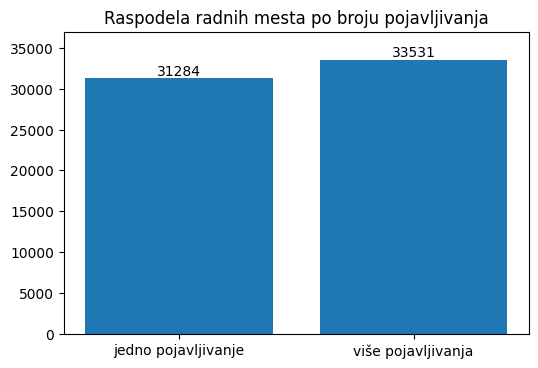

In [13]:
# Grafikon sa stubićima
def stubići(x, y, naslov):
    # Predstavljanje raspodele stubićima
    bar = plt.bar(x, y)

    # Obeležavanje stubića
    plt.bar_label(bar, y)

    # Povećavanje vrha da ne bude preklapanja
    plt.ylim(top=1.05*plt.ylim()[1])
    
    # Naslov grafikona
    plt.title(naslov)

# Određivanje brojeva ponavljanja
_, j = unikati([b > 1 for b in brjed])

# Raspodela pojavljivanja pomoću stubića
stubići(['jedno pojavljivanje', 'više pojavljivanja'], j,
        'Raspodela radnih mesta po broju pojavljivanja')

Dodatno su analizirana i najčešća ponavljanja. Skoro dvadeset hiljada puta ponavljaju se samo tri različite pozicije: [*chief executive officer*](https://en.wikipedia.org/wiki/Chief_executive_officer) (glavni izvršni direktor) sa nivoom *cxo* (direktor), *associate* (saradnik) sa nedostajućim nivoom i *managing director* (upravni direktor) sa nivoom *director* (upravnik).

In [14]:
# Indeksi za sortiranje po broju ponavljanja
indeksi = np.argsort(brjed)

# Sortiranje neredundantnih podataka po broju ponavljanja
podjed = podjed[indeksi]
brjed = brjed[indeksi]

# Ispis tri najčešća redundantna radna mesta
for i in range(-1, -4, -1):
    print(brjed[i], '–', podjed[i])

7382 – {
  name: chief executive officer,
  levels: ['cxo']
}
6624 – {
  name: associate,
  levels: []
}
5400 – {
  name: managing director,
  levels: ['director']
}


Nakon [čišćenja](https://en.wikipedia.org/wiki/Data_cleansing) duplikata, dakle, broj od ukupno 611.586 učitanih pozicija svodi se na 64.815 različtih. Međutim, duplikati nisu jedine sporne instance. Kako je ideja da klasifikacioni model nauči nivoe senioriteta (*levels*), beskorisna su sva radna mesta koja nisu obeležena po tom kriterijumu, što su ona koja na tom mestu imaju prazan niz, odnosno niz dužine nula. Dosta je takvih objekata, skoro pa svaki drugi.

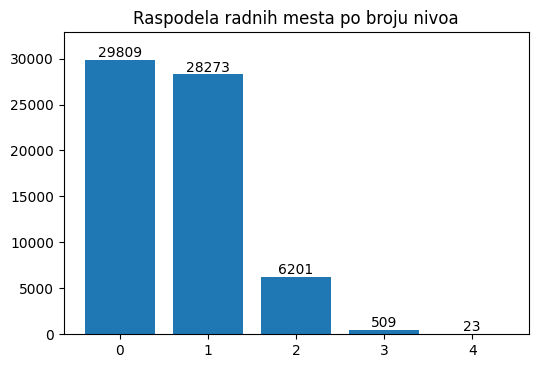

In [15]:
# Predstavljanje raspodele broja nivoa stubićima
stubići(*unikati([len(p.levels) for p in podjed]),
        'Raspodela radnih mesta po broju nivoa')

Kada se izdvoje samo obeležena radna mesta, dakle ona sa makar jednim nivoom, broj od 64.815 različitih spada na 35.006.

In [16]:
# Izdvajanje obeleženih radnih mesta
podobel = [p for p in podjed if p.levels]

# Izveštavanje o ukupom broju instanci
print('Ukupno učitanih radnih mesta:', len(podaci))

# Izveštavanje o broju jedinstvenih instanci
print('Ukupno različitih radnih mesta:', len(podjed))

# Izveštavanje o broju obeleženih instanci
print('Ukupno obeleženih radnih mesta:', len(podobel))

Ukupno učitanih radnih mesta: 611586
Ukupno različitih radnih mesta: 64815
Ukupno obeleženih radnih mesta: 35006


Zanimljivo je videti i koja su to radna mesta sa čak četiri nivoa u nizu. Primetno je da je reč o pozicijama koje su u suštini složene. U svakom slučaju, zadatak je primer [višelabelarne klasifikacije](https://en.wikipedia.org/wiki/Multi-label_classification), što znači da se ne traži tačno jedna oznaka, već njihov (neprazan) skup.

In [17]:
# Sortiranje podataka prema broju nivoa
podobel.sort(key=lambda p: (len(p.levels), p.name))

# Ispis tri najobeleženija radna mesta
for i in range(-1, -4, -1):
    print(podobel[i])

{
  name: senior vice president, head of marketing and institutional and retail sales,
  levels: ['senior', 'director', 'cxo', 'vp']
}
{
  name: senior vice president, director of strategy, mortgage operations,
  levels: ['senior', 'director', 'cxo', 'vp']
}
{
  name: senior vice president, director of special assets,
  levels: ['senior', 'director', 'cxo', 'vp']
}


Za kraj analize, korisno je nacrtati raspodelu klasa, kako bi se stekao uvid u balansiranost skupa. Primetno je da je najveći udeo menadžerskih pozicija, dok npr. početničkih ima vrlo malo. Inače, ukupno je deset klasa, što se može videti na priloženom grafikonu sa stubićima: *cxo* (direktor), *director* (upravnik), *entry* (početnik), *manager* (menadžer), *owner* (vlasnik), *partner* (partner), *senior* (senior), *training* (praktikant), *unpaid* (neplaćen/volonter), *vp* (potpredsednik).

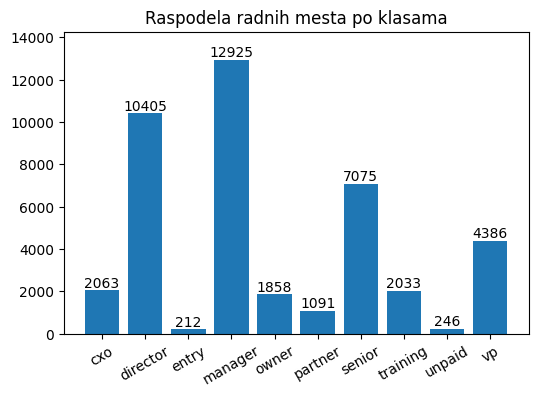

In [18]:
# Crtanje raspodele radnih mesta po klasama
def raspodela(skup):
    # Inicijalno prazan niz klasa
    klase = []

    # Dohvatanje klasa svih radnih mesta
    for p in skup:
        klase.extend(p.levels)

    # Predstavljanje raspodele broja nivoa stubićima
    stubići(*unikati(klase), 'Raspodela radnih mesta po klasama')

    # Rotacija naziva kako ne bi bilo preklapanja
    plt.xticks(rotation=30)

# Raspodela radnih mesta u celom skupu
raspodela(podobel)

### 1.3 Normalizacija teksta [⮭]<a id="par:norm"></a>

[⮭]: #par:prip

Normalizacija igra značajnu ulogu u klasifikaciji teksta. Poželjno je nazive radnih mesta učiniti što uniformnijim. Prvi korak u tome jeste [segmentacija teksta](https://en.wikipedia.org/wiki/Text_segmentation), što se u ovom slučaju svodi na izdvajanje reči i interpunkcije. Ovako izdvojene celine nazivaju se tokeni i mogu se dobiti pomoću modula [*NLTK*](https://www.nltk.org/) (`nltk`). Detaljnije informacije o normalizaciji teksta, regularnim izrazima i drugim srodnim temama mogu se naći u [drugom](https://web.stanford.edu/~jurafsky/slp3/2.pdf) poglavlju poznate knjige *SLP*.

In [19]:
# Modul za rad sa tekstom
import nltk

# Tokenizacija svakog radnom mesta
for p in podobel:
    p.tokeni = nltk.tokenize.word_tokenize(p.name)

In [20]:
# Ispis poslednjeg radnog mesta
print(podobel[-1].name)
print(podobel[-1].tokeni)

senior vice president, head of marketing and institutional and retail sales
['senior', 'vice', 'president', ',', 'head', 'of', 'marketing', 'and', 'institutional', 'and', 'retail', 'sales']


Dalje, dobro je da je svaka reč svedena na neki osnovni oblik. Ovo je moguće uraditi [stemovanjem](https://en.wikipedia.org/wiki/Stemming), što je proces koji heuristički pokušava da dođe do osnove reči. Alternativno, može se precizno pronaći koren (lema, rečnička forma) reči procesom [lematizacije](https://en.wikipedia.org/wiki/Lemmatisation). Oba su izvodljiva u učitanoj biblioteci *NLTK*. Važno je samo napomenuti da lematizator zahteva i vrstu reči kao argument, pa je za te potrebe iskorišćen ugrađeni obeleživač vrste reči ([*POS tagger*](https://en.wikipedia.org/wiki/Part-of-speech_tagging)). Sam lematizator zasnovan je na spisku različitih oblika reči prema [*WordNet*](https://en.wikipedia.org/wiki/WordNet)-u, najpoznatijoj i najrazvijenijoj leksičkoj bazi semantičkih odnosa reči. Detaljnije informacije o obeležavanju vrsta reči mogu se naći u [osmom](https://web.stanford.edu/~jurafsky/slp3/8.pdf), a o *WordNet*-u i njegovim mogućnostima u [osamnaestom](https://web.stanford.edu/~jurafsky/slp3/18.pdf) poglavlju poznate knjige *SLP*.

In [21]:
# Modul za rad sa naprednim rečnikom
from collections import defaultdict

# Rečnik koji je podrazumevano imenica
mapa = defaultdict(lambda: nltk.corpus.wordnet.NOUN)

# Popunjavanje ostalih skraćenica
mapa['J'] = nltk.corpus.wordnet.ADJ
mapa['S'] = nltk.corpus.wordnet.ADJ_SAT
mapa['V'] = nltk.corpus.wordnet.VERB
mapa['R'] = nltk.corpus.wordnet.ADV

# Funkcija za tagovanje
tag = lambda j: mapa[j[0]]

# Instanciranje lematizatora
lema = nltk.stem.WordNetLemmatizer()

# Određivanje vrste reči svakog radnog mesta
for p in podobel:
    pos = nltk.pos_tag(p.tokeni)
    
    # Lematizacija svakog tokena
    p.toklem = [lema.lemmatize(i, tag(j)) for i, j in pos]

In [22]:
# Ispis poslednjeg radnog mesta
print(podobel[-1].name)
print(podobel[-1].tokeni)
print(podobel[-1].toklem)

senior vice president, head of marketing and institutional and retail sales
['senior', 'vice', 'president', ',', 'head', 'of', 'marketing', 'and', 'institutional', 'and', 'retail', 'sales']
['senior', 'vice', 'president', ',', 'head', 'of', 'marketing', 'and', 'institutional', 'and', 'retail', 'sale']


Takođe, dobro je da je u opticaju neki manji skup karaktera, kako bi se dodatno smanjio broj jedinstvenih tokena. Primera radi, to mogu biti [*ASCII*](https://en.wikipedia.org/wiki/ASCII) karakteri, i to samo mala slova engleske latinice. U redu je odbaciti samostalnu interpunkciju, pa čak i onu koja postoji unutar reči (npr. *co-founder* može se svesti na *cofounder*). Spisak *ASCII* karaktera, znakova interpunkcije i mnoge druge informacije mogu se dobiti iz specijalizovanog ugrađenog modula [`string`](https://docs.python.org/3/library/string.html).

In [23]:
# Modul sa posebnim niskama
import string

# Skidanje zalepljene interpunkcije
strip = lambda t: ''.join(c for c in t if c in string.ascii_lowercase)

# Provera da li je interpunkcija
def punkt(t):
    for c in t:
        if c not in string.punctuation:
            return False
    return True

# Provera da li su sve mala ASCII slova
def aski(t):
    for c in t:
        if c not in string.ascii_lowercase and c not in string.punctuation:
            return False
    return True

# Izbacivanje svega što nisu mala ASCII slova
for p in podobel:
    p.tokpunk = [strip(t) for t in p.toklem if not punkt(t) and aski(t)]

In [24]:
# Ispis poslednjeg radnog mesta
print(podobel[-1].name)
print(podobel[-1].tokeni)
print(podobel[-1].tokpunk)

senior vice president, head of marketing and institutional and retail sales
['senior', 'vice', 'president', ',', 'head', 'of', 'marketing', 'and', 'institutional', 'and', 'retail', 'sales']
['senior', 'vice', 'president', 'head', 'of', 'marketing', 'and', 'institutional', 'and', 'retail', 'sale']


Za kraj, poželjno je ukloniti i takozvane [stop reči](https://en.wikipedia.org/wiki/Stop_word), za koje se očekuje da ne mogu doprineti klasifikaciji radnih mesta. To su npr. zamenice, veznici i slične leme bez semantike u kontekstu senioriteta. One bi u nastavku bespotrebno opteretile klasifikacione modele, a ne bi doprinele generalizaciji i kvalitetu.

In [25]:
# Dohvatanje stop reči u engleskom jeziku
stop = nltk.corpus.stopwords.words('english')

# Izbacivanje svih stop reči u engleskom jeziku
for p in podobel:
    p.tokstop = [t for t in p.tokpunk if t not in stop]

In [26]:
# Ispis poslednjeg radnog mesta
print(podobel[-1].name)
print(podobel[-1].tokeni)
print(podobel[-1].tokstop)

senior vice president, head of marketing and institutional and retail sales
['senior', 'vice', 'president', ',', 'head', 'of', 'marketing', 'and', 'institutional', 'and', 'retail', 'sales']
['senior', 'vice', 'president', 'head', 'marketing', 'institutional', 'retail', 'sale']


Spajanjem konačnog niza tokena može se dobiti nova tekstualna reprezentacija radnog mesta, čisto kompletnosti radi.

In [27]:
# Spajanje konačnog niza tokena u novo ime
for p in podobel:
    p.newname = ' '.join(p.tokstop)

In [28]:
# Ispis poslednjeg radnog mesta
print(podobel[-1].name)
print(podobel[-1].newname)

senior vice president, head of marketing and institutional and retail sales
senior vice president head marketing institutional retail sale


Nakon normalizacije, postoji nekoliko novih radnih mesta čija se imena poklapaju. Umesto 35.006, jedinstvenih imena zapravo je 33.067.

In [29]:
# Prvi primer ponovljenih radnih mesta
for i in (1, 6, 25476):
    print(podobel[i])

{
  name: 1st vice president,
  levels: ['vp']
}
{
  name: 2nd vice president,
  levels: ['vp']
}
{
  name: vice president,
  levels: ['vp']
}


In [30]:
# Drugi primer ponovljenih radnih mesta
for i in (97, 98):
    print(podobel[i])

{
  name: account executive - team lead,
  levels: ['manager']
}
{
  name: account executive -- team lead,
  levels: ['manager']
}


In [31]:
# Određivanje jedinstvenih normalizovanih imena
podnorm, _ = unikati(podobel)

# Izveštavanje o broju pre normalizacije
print('Ukupno radnih mesta pre normalizacije:', len(podobel))

# Izveštavanje o broju pre normalizacije
print('Ukupno radnih mesta nakon normalizacije:', len(podnorm))

Ukupno radnih mesta pre normalizacije: 35006
Ukupno radnih mesta nakon normalizacije: 33067


Pre preduzimanja daljih koraka, zanimljivo je grafički predstaviti i raspodelu broja tokena. Ukupno ih je 146.749, ali samo 7686 različitih.

In [32]:
# Inicijalno prazan niz tokena
tokeni = []

# Dohvatanje svih tokena
for p in podnorm:
    tokeni.extend(p.tokstop)

# Određivanje jedinstvenih tokena
tokjed, brjed = unikati(tokeni)

# Izveštavanje o ukupnom broju tokena
print('Ukupno tokena:', len(tokeni))

# Izveštavanje o broju različitih tokena
print('Različitih tokena:', len(tokjed))

Ukupno tokena: 146749
Različitih tokena: 7686


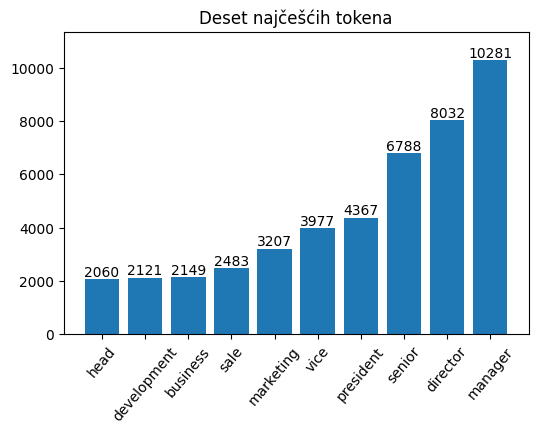

In [33]:
# Indeksi za sortiranje po broju ponavljanja
indeksi = np.argsort(brjed)

# Sortiranje jedinstvenih tokena po broju ponavljanja
tokjed = tokjed[indeksi]
brjed = brjed[indeksi]

# Crtanje deset najčešćih tokena
stubići(tokjed[-10:], brjed[-10:], 'Deset najčešćih tokena')

# Rotacija naziva kako ne bi bilo preklapanja
_ = plt.xticks(rotation=50)

Modul [`wordcloud`](https://github.com/amueller/word_cloud) omogućava pravljenje [oblaka reči](https://en.wikipedia.org/wiki/Tag_cloud), koji dodatno predstavlja česte bigrame poput *vice president* ili *senior manager*.

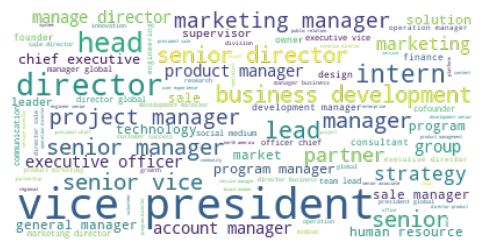

In [34]:
# Modul za generisanje oblaka reči
from wordcloud import WordCloud

# Instanciranje praznog oblaka reči
oblak = WordCloud(background_color=None, mode='RGBA', random_state=0)

# Generisanje oblaka na osnovu skupa tokena
oblak.generate(' '.join(tokeni))

# Grafički prikaz generisanog oblaka reči
plt.imshow(oblak, interpolation='bilinear')

# Isključivanje koordinatnog sistema
_ = plt.axis('off')

Značajan je i podataka o tome da li su neki tokeni jedinstveni. Takvih je više od pola i oni nemaju značaja u klasifikaciji zasnovanoj na rečima.

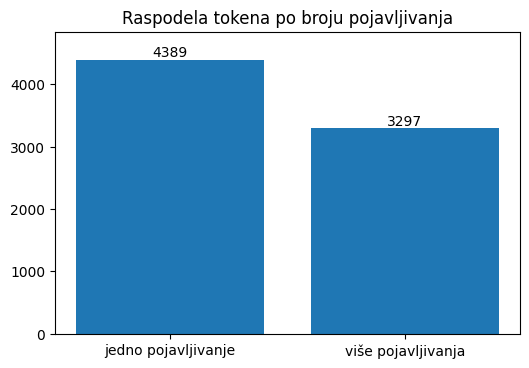

In [35]:
# Određivanje brojeva ponavljanja
_, j = unikati([b > 1 for b in brjed])

# Predstavljanje raspodele stubićima
stubići(['jedno pojavljivanje', 'više pojavljivanja'], j,
        'Raspodela tokena po broju pojavljivanja')

Zanimljivo je nacrtati i raspodelu dužina imena radnih mesta, odnosno broja tokena u konačnom lematizovanom i pročišćenom nizu.

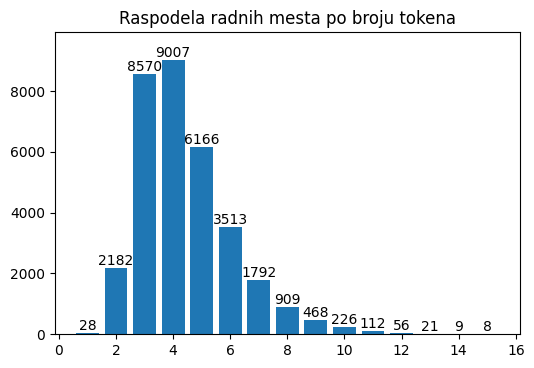

In [36]:
# Inicijalno prazan niz dužina
lens = []

# Dohvatanje svih tokena
for p in podnorm:
    lens.append(len(p.tokstop))

# Predstavljanje raspodele dužine stubićima
stubići(*unikati(lens), 'Raspodela radnih mesta po broju tokena')

## 2. Vektorizacija teksta [⮭]<a id="par:vekt"></a>

[⮭]: #par:toc

Imena su sada normalizovana. To, međutim, nije dovoljno kako bi bila prosleđena klasifikacionim modelima na obučavanje. Problem je što modeli mahom ne prihvataju tekst (niske) ili nizove tokena, već isključivo reprezentaciju u vidu vektora fiksne dužine. To znači da je imena neophodno vektorizovati.

### 2.1 Klasifikaciona pravila [⮭]<a id="par:prav"></a>

[⮭]: #par:vekt

Postavlja se pitanje kako od teksta napraviti vektor. Ideja se može pronaći u simboličkom *NLP*-ju, kao prvoj etapi obrade prirodnih jezika. On zagovara direktnu upotrebu [klasifikacionih pravila](https://en.wikipedia.org/wiki/Classification_rule) koja rade nad tekstom ili nizom tokena. Npr. može se pretpostaviti da svako ime koje sadrži reč *manager* predstavlja jednog menadžera (klasa *manager*), dok svaki potpredsednik (klasa *vp*) sadrži reč *vice*. Ovakva pravila mogu se i automatski pronaći [indukcijom](https://en.wikipedia.org/wiki/Rule_induction).

Uspešnost pravila ocenjuje se [dvema merama](https://en.wikipedia.org/wiki/Precision_and_recall): odzivom, koji je udeo prepoznatih instanci ciljane klase, i preciznošću, koja je udeo tačnih prepoznavanja.

$$ \text{odziv} = \frac{|\text{dohvaćeni ciljane klase}|}{|\text{svi ciljane klase}|} \; \; \; \; \; \; \text{preciznost} = \frac{|\text{dohvaćeni ciljane klase}|}{|\text{svi dohvaćeni}|} $$

In [37]:
# Funkcija koja ocenjuje predloženo pravilo
def oceni_pravilo(šablon, klasa):
    # Ispis predloženog pravila
    print('Pravilo:', šablon, '→', klasa, end='\n\n')
    
    # Inicijalno prazan niz klasa dohvaćenih instanci
    klase = []
    
    # Dohvatanje svih instanci prema pravilu
    for p in podnorm:
        if šablon in p.newname:
            klase.append(klasa in p.levels)
    
    # Računanje brojioca i imenilaca mera
    dck = sum(klase)
    sck = sum(klasa in p.levels for p in podnorm)
    sd = len(klase)
    
    # Ispis brojioca i imenilaca mera
    print('Dohvaćeni ciljane klase:', dck)
    print('Svi ciljane klase:', sck)
    print('Svi dohvaćeni:', sd, end='\n\n')
    
    # Računanje odziva i preciznosti
    odziv = dck / sck
    preciznost = dck / sd
    
    # Ispis odziva i preciznosti
    print('Odziv pravila:', odziv)
    print('Preciznost pravila:', preciznost, end='\n\n')
    
    # Ispis kontraprimera
    print('Kontraprimeri:')
    
    # Kontraprimer koji smanjuje preciznost
    for p in podnorm:
        if šablon in p.newname and klasa not in p.levels:
            print(p.name, p.levels)
            break
    
    # Kontraprimer koji smanjuje odziv
    for p in podnorm:
        if šablon not in p.newname and klasa in p.levels:
            print(p.name, p.levels)
            break

In [38]:
# Primer pravila visoke preciznosti
oceni_pravilo('manager', 'manager')

Pravilo: manager → manager

Dohvaćeni ciljane klase: 9985
Svi ciljane klase: 12492
Svi dohvaćeni: 10070

Odziv pravila: 0.7993115593980147
Preciznost pravila: 0.9915590863952334

Kontraprimeri:
assistant branch manager and senior business specialist ['senior']
academic program lead and national teaching fellow ['manager']


In [39]:
# Primer pravila visokog odziva
oceni_pravilo('vice', 'vp')

Pravilo: vice → vp

Dohvaćeni ciljane klase: 3862
Svi ciljane klase: 3871
Svi dohvaćeni: 5191

Odziv pravila: 0.9976750193748385
Preciznost pravila: 0.7439799653246003

Kontraprimeri:
account director, legal services ['director']
chief of staff to the regional managing partner of the u.s india offices ['vp', 'cxo']


In [40]:
# Primer skoro savršenog pravila
oceni_pravilo('senior', 'senior')

Pravilo: senior → senior

Dohvaćeni ciljane klase: 6726
Svi ciljane klase: 6734
Svi dohvaćeni: 6732

Odziv pravila: 0.9988119988119988
Preciznost pravila: 0.9991087344028521

Kontraprimeri:
glenn myles,senior managing director head of soverign wealth funds ['director']
campaign alliances manager ['senior']


Primetno je da pravila mogu biti vrlo precizna, pa i postići visoki odziv. Ona, međutim, zahtevaju stručnjake koji bi ih pisali i održavali, tako da se uglavnom ne koriste u praksi, osim u posebnim slučajevima ili u kombinaciji sa drugim metodama. Savremeni pristupi zasnovani su na automatskom učenju pravila ili makar njihovoj ugradnji u vektorsku reprezentaciju teksta koji se klasifikuje. Pravila, dakle, mogu biti polazna tačka za pravljenje vektora od teksta.

Primena klasifikacionih pravila zadire u oblasti [pretraživanja](https://en.wikipedia.org/wiki/Information_retrieval) (*information retrieval*, *IR*) i [ekstrakcije informacija](https://en.wikipedia.org/wiki/Information_extraction) (*information extraction*, *IE*) i njima srodne discipline. Više o tome može se videti u [osmom](https://web.stanford.edu/~jurafsky/slp3/8.pdf), [sedamnaestom](https://web.stanford.edu/~jurafsky/slp3/17.pdf) i [dvadeset trećem](https://web.stanford.edu/~jurafsky/slp3/23.pdf) poglavlju poznate knjige *Speech and Language Processing*.

### 2.2 Retke reprezentacije [⮭]<a id="par:retk"></a>

[⮭]: #par:vekt

Ugradnja pravila u vektorsku reprezentaciju teksta može biti ručna, tako što se svojstva (karakteristike, [*features*](https://en.wikipedia.org/wiki/Feature_%28machine_learning%29)) izgrađuju na osnovu predefinisanih šablona. Prema prethodnim pravilima, mogla bi se [napraviti](https://en.wikipedia.org/wiki/Feature_engineering) istinitosna svojstva `sadrži(manager)` i `sadrži(senior)` koja bi bila `True` (`1`) za imena koja sadrže reči (tokene, podniske) *manager*, odnosno *vice*, a `False` (`0`) za ostale instance. Slično se mogu napraviti i druga ručno smišljena važna svojstva (detalji se mogu videti [ovde](https://towardsdatascience.com/job-title-analysis-in-python-and-nltk-8c7ba4fe4ec6)), npr. ona koja pamte prvu i poslednju reč ili broj tokena. Ovakve karakteristike uglavnom su diskretne, mada to ne mora biti slučaj.

Predloženi način vektorizacije teksta gradi takozvane retke reprezentacije. To znači da u njima velika većina karakteristika ima vrednost `False` (`0`), a tek poneka `True` (`1`). Osim toga, broj svojstava je često veoma veliki, što otežava obučavanje modela. Ipak, ovakve reprezentacije teksta su vrlo korišćene i pokazale su se kao uspešne. U praksi, međutim, ne grade se ručno, već se koriste različiti vektorizatori, koji izgrađuju različite retke reprezentacije. Oni grade kostur reprezentacije na osnovu skupa za obučavanje, pa je neophodno [podeliti](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) pripremljeni skup, što je ovde učinjeno kao $33.067 = 24.800 + 8267$. Nadalje je za mnoge česte zadatke u radu sa podacima, kao i za mašinsko učenje, korišćen modul [`scikit-learn`](https://scikit-learn.org/stable/), poznat i kao `sklearn`. Detaljnije informacije o vektorskom predstavljanju teksta mogu se naći u [šestom](https://web.stanford.edu/~jurafsky/slp3/6.pdf) poglavlju poznate knjige *Speech and Language Processing*.

In [41]:
# Modul za podelu na skup za obučavanje i proveru
from sklearn.model_selection import train_test_split

# Podela podataka na dva odvojena dela
train, test = train_test_split(podnorm, random_state=0)

# Ispis broja instanci u odvojenim delovima
print('Radnih mesta u skupu za obučavanje:', len(train))
print('Radnih mesta u skupu za proveru:', len(test))

Radnih mesta u skupu za obučavanje: 24800
Radnih mesta u skupu za proveru: 8267


Značajno je utvrditi da nije došlo do poremećaja raspodele klasa nakon podele, odnosno da je raspodela na skupu za obučavanje i proveru identična.

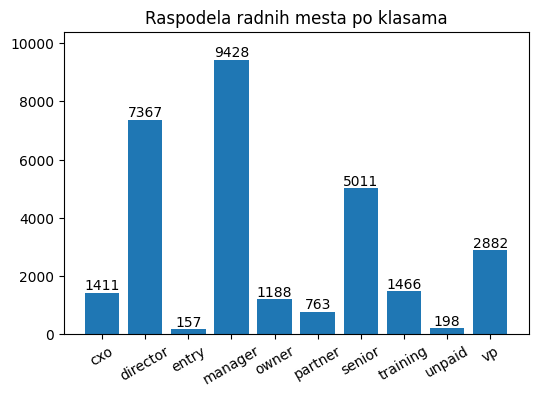

In [42]:
# Raspodela radnih mesta u trening skupu
raspodela(train)

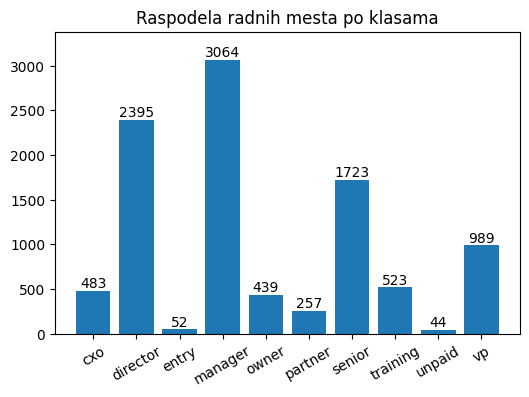

In [43]:
# Raspodela radnih mesta u test skupu
raspodela(test)

Poznata vrsta reprezetancije jesu [*n*-gramski](https://en.wikipedia.org/wiki/N-gram) modeli. Naime, mogu se posmatrati sve moguće susedne *n*-torke nekih jedinica (reči, karaktera ili čak bajtova) koji postoje, pri čemu svaka *n*-torka predstavlja jedno svojstvo. Ovakvi modeli daju dobre rezultate u pojedinim primenama, kao što je određivanje jezika na kom je tekst napisan. Dobra strana im je što što uzimaju u obzir raspored jedinica, ali dobijeni vektori, s druge strane, mogu biti preveliki i previše retki. Detaljnije informacije o *n*-gramskim modelima jezika i drugim srodnim temama mogu se naći u [trećem](https://web.stanford.edu/~jurafsky/slp3/3.pdf) poglavlju poznate knjige *SLP*.

<img src="../slike/n-gram.png" alt="Ilustracija n-gramskih modela" width="55%"/>

*N*-gramski modeli sa velikom vrednošću parametra *n* i/ili sa sitnim jedinicama (karakterima ili bajtovima) ipak se nešto ređe koriste. Umesto njih, u upotrebi je [vreća reči](https://en.wikipedia.org/wiki/Bag-of-words_model), koja odgovara unigramskom (*n*-gramskom za $n = 1$) modelu nad rečima. Tekst se u ovom modelu predstavlja vektorom kod koga je svako svojstvo jedna reč iz rečnika, a njegova vrednost zavisi od pojavljivanja te reči u tekstu. Ukoliko se reč ne pojavljuje, vrednost vektora na tom mestu je `0` ili `False`, dok je u suprotnom `1` ili `True` ili pak tačan broj pojavljivanja (nenegativan ceo broj). Ovaj model efektivno zanemaruje položaj i odnose reči u tekstu. Može se primetiti da ovaj princip umnogome odgovara već predstavljenom izdvajanju svojstava na osnovu pravila, odnosno prefedefinisanih šablona.

<img src="../slike/bow.png" alt="Ilustracija vreće reči" width="55%"/>

In [44]:
# Modul za rad sa vrećom reći
from sklearn.feature_extraction.text import CountVectorizer

# Instanciranje binarnog vektorizatora sa makar tri pojavljivanja
bow = CountVectorizer(min_df=3, binary=True)

# Obučavanje na skupu za trening
_ = bow.fit([p.newname for p in train])

In [45]:
# Ispis naučenih svojstava
print(len(bow.vocabulary_),
      bow.get_feature_names_out())

1895 ['aadvantage' 'ab' 'abm' ... 'zealand' 'zonal' 'zone']


In [46]:
# Vektorizacija BOW-om
bowuj = lambda p: bow.transform([p.newname])

# Ispis kodiranja prve instance
print(bowuj(train[0]))

  (0, 487)	1
  (0, 755)	1
  (0, 1042)	1
  (0, 1054)	1
  (0, 1554)	1


In [47]:
# Vektorizacija skupa za obučavanje
for p in train:
    p.bow = bowuj(p).toarray()[0]
    
# Vektorizacija skupa za proveru
for p in test:
    p.bow = bowuj(p).toarray()[0]

Pored binarnog predstavljanja ili tačnog broja pojavljivanja (frekvencije) reči, često se koristi i takozvana [*tf-idf*](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (*term frequency–inverse document frequency*) frekvencija, koja bi se na srpskom mogla nazvati merom *fa-ifd* (frekvencija atributa, inverzna frekvencija dokumenta). Ova statistika svedoči o značaju reči umesto o prostom broju pojavljivanja. Direktno je srazmerna broju pojavljivanja reči u datom dokumentu za koji se izračunava, a obrnuto srazmerna ukupnom broju dokumenata koji sadrže tu reč. Tako su otežane česte reči u nekom tekstu, ali su olakšane one koje se nalaze u mnogim različitim tekstovima.

<img src="../slike/tf-idf.jpeg" alt="Ilustracija tf-idf frekvencije" width="55%"/>

In [48]:
# Modul za rad sa tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Instanciranje tf-idf vektorizatora sa makar tri pojavljivanja
tfidf = TfidfVectorizer(min_df=3)

# Obučavanje na skupu za trening
_ = tfidf.fit([p.newname for p in train])

In [49]:
# Ispis naučenih svojstava
print(len(tfidf.vocabulary_),
      tfidf.get_feature_names_out())

1895 ['aadvantage' 'ab' 'abm' ... 'zealand' 'zonal' 'zone']


In [50]:
# Vektorizacija tf-idf-om
tfidfuj = lambda p: tfidf.transform([p.newname])

# Ispis kodiranja prve instance
print(tfidfuj(train[0]))

  (0, 1554)	0.23855647509402927
  (0, 1054)	0.30821701555208136
  (0, 1042)	0.20034358545039593
  (0, 755)	0.6492409390613321
  (0, 487)	0.621644376094982


In [51]:
# Vektorizacija skupa za obučavanje
for p in train:
    p.tfidf = tfidfuj(p).toarray()[0]

# Vektorizacija skupa za proveru
for p in test:
    p.tfidf = tfidfuj(p).toarray()[0]

### 2.3 Guste reprezentacije [⮭]<a id="par:gust"></a>

[⮭]: #par:vekt

Upotreba retkih reprezentacija uz metode mašinskog učenja odlika je statističkog *NLP*-ja, kao druge etape razvoja obrade prirodnih jezika. U aktuelnoj, trećoj etapi, fokus je na dubokom učenju i gustim reprezentacijama. Za razliku od prethodno razmatranih vektora, koji su izrazito dugački (na konkretnom primeru: 1895, po jedan atribut za svaku različitu reč u trening skupu), ali retki (na konkretnom primeru: najviše desetak nenula vrednosti), nove reprezentacije imaju znatno manji broj karakteristika realnog tipa, pri čemu nijedna nije nula. Osmišljeni su tako da su [kosinusno](https://en.wikipedia.org/wiki/Cosine_similarity) sličniji vektori koji opisuju sličnije tekstove.

<img src="../slike/cosine.png" alt="Ilustracija kosinusne sličnosti" width="55%"/>

Veliki je broj gustih modela, kao što su [*Word2Vec*](https://en.wikipedia.org/wiki/Word2vec), [*GloVe*](https://en.wikipedia.org/wiki/GloVe), [*fastText*](https://en.wikipedia.org/wiki/FastText) ili [*ELMo*](https://en.wikipedia.org/wiki/ELMo). Oni, međutim, mahom rade nad rečima umesto nad složenim tekstom ili su zahtevni (hardverski i vremenski) za rad. Poznati model koji nije preterano zahtevan, a pritom je u stanju da smisleno vektorizuje ceo tekst jeste [*BERT*](https://en.wikipedia.org/wiki/BERT_%28language_model%29). Zasnovan je na [transformeru](https://en.wikipedia.org/wiki/Transformer_%28machine_learning_model%29), složenoj dubokoj neuronskoj mreži sa mehanizmom [pažnje](https://en.wikipedia.org/wiki/Attention_%28machine_learning%29). Koristi se unapred trenirani model, koji se zatim profinjuje (*fine-tuning*) na konkretnom problemu (ovde klasifikaciji), što je takozvani [transfer učenja](https://en.wikipedia.org/wiki/Transfer_learning). Umesto punog modela, najčešće se koristi neka uprošćena verzija, kao što je [*DistilBERT*](https://huggingface.co/docs/transformers/model_doc/distilbert), koji ima 40% manje parametara, 60% je brži, a zadržava čak 97% uspešnosti. Dostupan je kroz modul [*Sent2Vec*](https://github.com/pdrm83/sent2vec) (`sent2vec`). Detaljnije informacije o dubokim modelima jezika mogu se naći u [sedmom](https://web.stanford.edu/~jurafsky/slp3/7.pdf), [osmom](https://web.stanford.edu/~jurafsky/slp3/8.pdf), [devetom](https://web.stanford.edu/~jurafsky/slp3/9.pdf), [desetom](https://web.stanford.edu/~jurafsky/slp3/10.pdf) i [jedanaestom](https://web.stanford.edu/~jurafsky/slp3/11.pdf) poglavlju poznate knjige *SLP*.

<img src="../slike/bert.png" alt="Ilustracija BERT-a" width="55%"/>

In [52]:
# Modul za rad sa transformerima
from transformers import logging

# Modul za rad sa BERT-om
from sent2vec.vectorizer import Vectorizer as BERTVectorizer

# Isključivanje neželjenih upozorenja
logging.set_verbosity_error()

# Instanciranje BERT vektorizatora
bert = BERTVectorizer()

Initializing Bert distilbert-base-uncased
Vectorization done on cpu


Ispisom konfiguracije modela, može se primetiti da *DistilBERT* ima vokabular veličine 30.522 reči, što je znatno više od 1895 kod prethodno razmatrane vreće reči, dok je dimenzija rezultujućih gustih vektora 768, što je znatno manje. Ovakve guste reprezentacije nazivaju se i u ugrađivanjima ([*embedding*](https://en.wikipedia.org/wiki/Word_embedding)).

In [53]:
# Ispis konfiguracije modela
print(bert.vectorizer.model.config)

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.1",
  "vocab_size": 30522
}



Kako ugrađivanje može da potraje, korisno je čuvati rezultujuće vektore na lokalu, te ih ne izračunavati više od jednom po jedinstvenom radnom mestu. Za skladištenje jednom izračunate *BERT* vektorizacije usput se koristi ugrađeni modul [`os`](https://docs.python.org/3/library/os.html), specijalizovan za rad sa operativnim sistemom.

In [54]:
# Modul za rad sa operativnim sistemom
import os

# Funkcija za sigurno otvaranje fajla
def fopen(fajl, mod):
    # Pravljenje potrebnih direktorijuma
    os.makedirs(os.path.dirname(fajl), exist_ok=True)
    
    # Otvaranje fajla u željenom modu
    return open(fajl, mod)

# Vektorizacija BERT-om
def bertuj(p):
    try:
        # Pokušaj čitanja sa lokala
        with open(f'../bert/{p.newname}.txt', 'r') as f:
            p.bert = eval(f.read())
    
    except:
        # Predviđanje nove instance
        bert.run([p.newname])
        
        # Pamćenje BERT vektorizacije
        p.bert = [*bert.vectors[-1]]
        
        # Pražnjenje niza predviđanja
        bert.vectors = []
        
        # Upisivanje na lokal za ubuduće
        with fopen(f'../bert/{p.newname}.txt', 'w') as f:
            f.write(str(p.bert))

# Vektorizacija prve instance
bertuj(train[0])

# Dohvatanje vektora prve instance
prva = train[0].bert

# Ispis kodiranja prve instance
with np.printoptions(threshold=0):
    print(len(prva), np.array(prva))

768 [-0.22020869  0.02503072 -0.20664074 ... -0.2911987   0.14983544
  0.27968505]


In [55]:
# Vektorizacija skupa za obučavanje
#for p in train: bertuj(p)

# Vektorizacija skupa za proveru
#for p in test: bertuj(p)

## 3. Klasifikacija teksta [⮭]<a id="par:klas"></a>

[⮭]: #par:toc

Nakon što je tekst uspešno vektorizovan, konačno ga je moguće klasifikovati. [Klasifikacija](https://en.wikipedia.org/wiki/Statistical_classification) je problem određivanja kojim klasama (kategorijama) neki objekat pripada, odnosno učenje optimalne funkcije odluke. U konkretnom slučaju, objekti su radna mesta (tekstualna ili vektorizovana), a klase nivoi senioriteta.

### 3.1 Višelabelarna klasifikacija [⮭]<a id="par:multi"></a>

[⮭]: #par:klas

Kada instanci može biti pridruženo više oznaka, reč je o [višelabelarnoj klasifikaciji](https://en.wikipedia.org/wiki/Multi-label_classification), što znači da se traži (neprazan) skup oznaka. Upravo je to slučaj kod razmatranih radnih mesta. S druge strane, na ilustraciji koja sledi instanca je slika, dok su klase tipovi objekata koji su prepoznati na slici.

<img src="../slike/multilabel.png" alt="Ilustracija vrsta klasifikacije" width="75%"/>

Za rešavanje problema višelabelarne klasifikacije, najčešće se koriste binarni vektori fiksne dužine (koja odgovara broju klasa) umesto varijabilne liste oznaka, npr. `[0 0 0 1 0 0 1 0 0 0]` umesto `['manager' 'senior']`. Ovo je neophodno zarad uniformnosti algoritama i optimizacije prilikom obučavanja.

In [56]:
# Oznake skupa za obučavanje
y_train = [p.levels for p in train]

# Oznake skupa za proveru
y_test = [p.levels for p in test]

In [57]:
# Modul za rad sa višestrukim oznakama
from sklearn.preprocessing import MultiLabelBinarizer

# Instanciranje i obučavanje binarizatora
mlb = MultiLabelBinarizer().fit(y_train)

# Ispis primećenih klasa u obuci
print(mlb.classes_)

['cxo' 'director' 'entry' 'manager' 'owner' 'partner' 'senior' 'training'
 'unpaid' 'vp']


In [58]:
# Binarizacija skupa za obučavanje
y_train_bin = mlb.transform(y_train)

# Binarizacija skupa za proveru
y_test_bin = mlb.transform(y_test)

In [59]:
# Ispis primera osnovnih oznaka
print(y_train[:3])

[['manager', 'senior'], ['manager'], ['vp']]


In [60]:
# Ispis primera binarizovanih oznaka
print(y_train_bin[:3])

[[0 0 0 1 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]


Najpoznatija strategija višelabelarne klasifikacije sa *k* klasa jeste treniranje *k* različitih klasifikatora, po jedan za svaku klasu. Na taj način je problem sveden na *k* [binarnih klasifikacija](https://en.wikipedia.org/wiki/Binary_classification), što je teorijski vrlo razrađena oblast. Izlazi ovih klasifikatora kombinuju se u jedan zajednički izlaz, koji je predviđanje date instance. Ovaj princip jednostavno se apstrahuje i automatizuje korišćenjem omotača za višelabelarnu klasifikaciju iz učitanog modula `sklearn`.

In [61]:
# Modul za rad sa višelabelarnom klasifikacijom
from sklearn.multioutput import MultiOutputClassifier

# Omotač za rad sa višelabelarnom klasifikacijom
def klasifikator(klasa, *args, **kwargs):
    return MultiOutputClassifier(klasa(*args, **kwargs))

Korisno je unapred izdvojiti i sve elemente skupova za obučavanje i proveru, kako bi odmah bili spremni za upotrebu kada dođe vreme za to.

In [62]:
# Izdvajanje vreće reči skupova
X_train_bow = [p.bow for p in train]
X_test_bow = [p.bow for p in test]

# Izdvajanje tf-idf vrednosti skupova
X_train_tfidf = [p.tfidf for p in train]
X_test_tfidf = [p.tfidf for p in test]

# Izdvajanje BERT vrednosti skupova
#X_train_bert = [p.bert for p in train]
#X_test_bert = [p.bert for p in test]

### 3.2 Bajesovski klasifikator [⮭]<a id="par:bajes"></a>

[⮭]: #par:klas

Sada je sve spremno za samu klasifikaciju. Jedan od najpoznatijih klasifikatora teksta jeste [naivni Bajes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier). Ovaj [probabilistički model](https://en.wikipedia.org/wiki/Probabilistic_classification) na osnovu skupa za obučavanje izračunava apriorne verovatnoće ([*prior*](https://en.wikipedia.org/wiki/Prior_probability)) svake od klasa, kao i uslovnu raspodelu ([*likelihood*](https://en.wikipedia.org/wiki/Likelihood_function)) svakog atributa u svakoj klasi. Kako zapravo modeluje zajedničku raspodelu atributa i klasa, naivni Bajes je [generativni model](https://en.wikipedia.org/wiki/Generative_model). U fazi predviđanja, model [maksimizuje aposteriornu verovatnoću](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (*MAP*) po klasama. Naivna (u teoriji jaka, ali u praksi korisna) pretpostavka modela jeste uslovna nezavisnost pojedinačnih atributa u svakoj klasi, takva da se uslovna verovatnoća složenog vektora atributa u svakoj klasi dobija množenjem jednostavnih uslovnih verovatnoća pojedinačnih atributa u istoj klasi.

<img src="../slike/bayes.png" alt="Ilustracija naivnog Bajesa" width="50%"/>

Pretpostavljena uslovna raspodela atributa zavisi od samog problema. U slučaju indikatorskih svojstava, ona je [Bernulijeva](https://en.wikipedia.org/wiki/Bernoulli_distribution), u slučaju većeg broja neuređenih vrednosti [kategorička](https://en.wikipedia.org/wiki/Categorical_distribution), a u slučaju normalno raspodeljenih veličina [Gausova](https://en.wikipedia.org/wiki/Normal_distribution). Na konkretnom primeru teksta, reprezentacija u vidu vreće reči je indikatorskog tipa. Detaljnije informacije o klasifikaciji teksta i naivnom Bajesu mogu se naći u [četvrtom](https://web.stanford.edu/~jurafsky/slp3/4.pdf) poglavlju poznate knjige *Speech and Language Processing*.

In [63]:
# Modul za rad sa naivnim Bajesom
from sklearn.naive_bayes import BernoulliNB

# Bernulijev naivni Bajes za vreću reči
bnb_bow = klasifikator(BernoulliNB)

# Obučavanje instaniranog klasifikatora
bnb_bow.fit(X_train_bow, y_train_bin)

# Ilustracija obučenog klasifikatora
display(bnb_bow)

MultiOutputClassifier(estimator=BernoulliNB())

### 3.3 Logistička regresija [⮭]<a id="par:logit"></a>

[⮭]: #par:klas

Naivnom Bajesu je srodan model [logističke regresije](https://en.wikipedia.org/wiki/Logistic_regression). Ovaj [diskriminativni model](https://en.wikipedia.org/wiki/Discriminative_model) linearnom funkcijom predstavlja [logaritamski odnos](https://en.wikipedia.org/wiki/Logit) (*logit* ili *log-odds*) verovatnoće pripadnosti nekoj klasi, dok se sama verovatnoća izračunava [sigmoidnom](https://en.wikipedia.org/wiki/Sigmoid_function) ([logističkom](https://en.wikipedia.org/wiki/Logistic_function)) funkcijom. Sigmoidna funkcija mapira ceo skup realnih brojeva u interval $(0, 1)$, pa se smatra da kazuje o sigurnosti modela u pripadnost razmatranoj klasi. Parametri se najčešće obučavaju minimizacijom binarne [unakrsne entropije](https://en.wikipedia.org/wiki/Cross_entropy), što je [funkcija greške](https://en.wikipedia.org/wiki/Loss_function) koja sumira negativne sigurnosti u stvarne oznake, za koje je očekivano da budu što veće.

<img src="../slike/logit.png" alt="Ilustracija logističke regresije" width="50%"/>

[Stohastički gradijentni spust](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) je poznati metod minimizacije koji se često koristi. Pritom se skoro podrazumevano koristi i [regularizacija](https://en.wikipedia.org/wiki/Regularization_(mathematics)), s ciljem da spreči [preprilagođavanje](https://en.wikipedia.org/wiki/Overfitting) parametara skupu za obuku. *L2* regularizacija podrazumeva dodavanje [euklidske](https://en.wikipedia.org/wiki/Euclidean_space) norme funkciji greške i najčešće se koristi. Ipak, zanimljivije je koristiti *L1* regularzaciju, koja grešci dodaje [taksi](https://en.wikipedia.org/wiki/Taxicab_geometry) normu, što mnoge parametre svodi na nulu i time značajno povećava interpretabilnost modela (uz nevažne atribute idu nulti koeficijenti). Detaljnije informacije o logističkoj regresiji i ostalim srodnim temama mogu se naći u [petom](https://web.stanford.edu/~jurafsky/slp3/5.pdf) poglavlju knjige *SLP*.

In [64]:
# Modul za rad sa logističkom regresijom
from sklearn.linear_model import LogisticRegression

# Logistička regresija za vreću reči
lr_bow = klasifikator(LogisticRegression, penalty='l1',
                      solver='liblinear', random_state=0)

# Obučavanje instaniranog klasifikatora
lr_bow.fit(X_train_bow, y_train_bin)

# Ilustracija obučenog klasifikatora
display(lr_bow)

MultiOutputClassifier(estimator=LogisticRegression(penalty='l1', random_state=0,
                                                   solver='liblinear'))

### 3.4 Metod potpornih vektora [⮭]<a id="par:svm"></a>

[⮭]: #par:klas

Još jedan poznati matematički zasnovan klasifikator jeste [metod potpornih vektora](https://en.wikipedia.org/wiki/Support-vector_machine) (*SVM*). Osnovna ideja je da se u vektorskom prostoru podataka pronađe najbolja hiperravan koja dobro razdvaja instance iz različitih klasa. U fazi obučavanja, takva hiperravan nalazi se maksimizacijom širine razdvajajućeg pojasa (margine), odnosno minimizacijom norme vektora ravni. Optimizacija se, očekivano, odvija pod uslovom što bolje klasfikacije skupa za obučavanje. Drugim rečima, optimizatoru se nameće ograničenje sa koje strane ravni treba da se nalazi koja instanca, pa se minimizuje [greška u vidu šarke](https://en.wikipedia.org/wiki/Hinge_loss) (*hinge*).

<img src="../slike/svm.png" alt="Ilustracija metoda potpornih vektora" width="70%"/>

U teoriji, ovako formulisan problem podrazumeva strogu linearnu razdvojivost podataka. U praksi, najčešće se koristi meka margina, koja dozvoljava određene male greške, a usput predstavlja i način regularizacije. Ukoliko nije moguće linearno razdvojiti podatke ni mekom marginom, pribegava se upotrebi [kernel trika](https://en.wikipedia.org/wiki/Kernel_method). Naime, moguće je dualno formulisati opisani problem optimizacije, tako da se u formuli ne nalaze vektori pojedinačnih trening instanci, već isključivo njihov [skalarni proizvod](https://en.wikipedia.org/wiki/Dot_product). Taj proizvod, budući [mera sličnosti](https://en.wikipedia.org/wiki/Similarity_measure) u prostoru podataka, može se zameniti nekim kernelom, koji, održavajući sličnost, implicitno mapira podatke u vektorski prostor veće (možda čak i beskonačne) dimenzije, u kom klase verovatno jesu linearno razdvojive. Među najpoznatijim je [*RBF* kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel), ali uspeh logističke regresije svedoči o tome da je za konkrentan problem dovoljan linearni kernel, te i da nema potrebe za rešavanjem dualnog problema.

In [65]:
# Modul za metod potpornih vektora
from sklearn.svm import LinearSVC

# Logistička regresija za vreću reči
lsvc_bow = klasifikator(LinearSVC, penalty='l1',
                        dual=False, random_state=0)

# Obučavanje instaniranog klasifikatora
lsvc_bow.fit(X_train_bow, y_train_bin)

# Ilustracija obučenog klasifikatora
display(lsvc_bow)

MultiOutputClassifier(estimator=LinearSVC(dual=False, penalty='l1',
                                          random_state=0))

### 3.5 Algoritam najbližih suseda [⮭]<a id="par:knn"></a>

[⮭]: #par:klas

Za razliku od dosad razmatranih klasifikatora, koji su imali relativno složenu matematičku pozadinu i veći broj parametara srazmeran broju atributa, [algoritam najbližih suseda](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) je primer jednostavnog neparametarskog modela nadgledanog učenja. Ovaj model implicitno aproksimira gustinu raspodele podataka na osnovu instanci iz skupa za obučavanje. Faza treniranja u suštini ni ne postoji, budući da se svodi na prosto pamćenje svih podataka. U fazi predviđanja, instanci se dodeljuje klasa kojoj pripada većina od $k$ (hiperparametar) najbližih suseda prema nekoj meri rastojanja, npr. [kosinusnom](https://en.wikipedia.org/wiki/Cosine_similarity) u slučaju teksta.

<img src="../slike/knn.png" alt="Ilustracija algoritma najbližih suseda" width="35%"/>

Pored mere rastojanja i broja suseda $k$, koji je svojevrsna mera regularizacije, važan je i sam algoritam određivanja najbližih suseda. Gruba sila, budući kvadratne složenosti, smislena je samo na sasvim malim skupovima. Umesto toga, najčešće se koristi neka napredna geometrijska struktura podataka poput [$k$-d](https://en.wikipedia.org/wiki/K-d_tree) ili [loptastog](https://en.wikipedia.org/wiki/Ball_tree) (metričkog) stabla. Takođe, kako nema parametara, sada je dovoljan samo jedan model, npr. onaj iz biblioteke [`scikit-multilearn`](http://scikit.ml/index.html).

In [66]:
# Modul za algoritam najbližih suseda
from skmultilearn.adapt import MLkNN

# Klasa adapter za skmultilearn
class KNN(MLkNN):
    # Konstrukcija KNN klasifikatora
    def __init__(self, *args, **kwargs):
        super(KNN, self).__init__(*args, **kwargs)
        
        # Pamćenje samog sebe kao modela
        self.estimator = self
    
    # Predviđanje na skupu za proveru
    def predict(self, X):
        return super(KNN, self).predict(np.array(X))
    
    # Predviđanje verovatnoća obeležja
    def predict_proba(self, X):
        probs = super(KNN, self).predict_proba(np.array(X))
        
        # Preuređivanje verovatnoća prema sklearn
        return [np.array([[1-probs[o, c], probs[o, c]]
                          for o in range(probs.shape[0])])
                for c in range(probs.shape[1])]

In [67]:
# Algoritam najbližih suseda za vreću reči
knn_bow = KNN()

# Obučavanje instaniranog klasifikatora
knn_bow.fit(X_train_bow, y_train_bin)

# Ilustracija obučenog klasifikatora
display(knn_bow)

KNN(ignore_first_neighbours=0, k=10, s=1.0)

## 4. Analiza rezultata [⮭]<a id="par:rezul"></a>

[⮭]: #par:toc

Svi klasifikacioni modeli ukalupljuju se u obeleženi skup za obučavanje. Parametri modela podešavaju se tako da predviđene klase u fazi predikcije budu što sličnije prosleđenim obeležjima, odnosno da greška bude što manja. Naravno, ne očekuje se da se model savršeno prilagodi trening skupu. To bi, štaviše, bilo problematično jer bi se izgubilo na generalizaciji i naziva se problemom [preprilagođavanja](https://en.wikipedia.org/wiki/Overfitting). S druge strane, može doći i do potprilagođavanja, kada model ne uspeva da uhvati pravilnosti u podacima. Poželjno je u fazi provere oceniti moć modela i generalizacije. Takođe, korisno je pokušati sa interpretacijom načina na koji prediktor radi, odnosno kako donosi odluke. Detaljnije informacije o klasifikaciji i njenoj uspešnosti mogu se naći u [četvrtom](https://web.stanford.edu/~jurafsky/slp3/4.pdf) poglavlju knjige *SLP*.

### 4.1 Matrica konfuzije [⮭]<a id="par:konf"></a>

[⮭]: #par:rezul

Osnovni alat za proveru klasifikacionih modela jeste [matrica konfuzije](https://en.wikipedia.org/wiki/Confusion_matrix), koja slikovito prikazuje koliko instanci je tačno kategorizovano. Redovi ove matrice predstavljaju stvarne, a kolone predviđene klase. Idealno, matrica je [dijagonalna](https://en.wikipedia.org/wiki/Diagonal_matrix), što znači da se stvarna i predviđena klasa uvek poklapaju. Kod višelabelarne klasifikacije, međutim, ne postoji jedna matrica konfuzije, već *k* njih, za svaki unutrašnji binarni klasifikator po jedna. Matrice je moguće lepo vizuelizovati.

<img src="../slike/konfuzija.jpeg" alt="Ilustracija matrice konfuzije" width="50%"/>

Na matrici konfuzije mogu se uočiti četiri tipa instanci: tačno klasfikovane stvarno negativne (*TN*) i stvarno pozitivne (*TP*), kao i [pogrešno kategorizovane](https://en.wikipedia.org/wiki/False_positives_and_false_negatives) lažno pozitivne (*FP*) i lažno negativne (*FN*). Od problema zavisi koja od ove četiri kategorije je najvažnija, odnosno na koju je neophodno obratiti najveću pažnju.

In [68]:
# Modul za rad sa matricama konfuzije
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Funkcija za crtanje matrica konfuzije
def konfuzija(model, X_test, y_true):
    # Pravljenje podgrafika za sve matrice
    fig, axs = plt.subplots(2, 5, figsize=(8, 4),
                            sharex=True, sharey=True)
    
    # Predviđanje na skupu za proveru
    y_pred = model.predict(X_test)
    
    # Izračunavanje binarnih matrica konfuzije
    matrice = multilabel_confusion_matrix(y_true, y_pred)
    
    # Crtanje svake pojedinačne matrice konfuzije
    for ax, mat, ime in zip(axs.ravel(), matrice, mlb.classes_):
        ConfusionMatrixDisplay(mat).plot(cmap='binary', colorbar=False, ax=ax)
        
        # Postavljanje imena na tekuću klasu
        ax.set_title(ime)
        
        # Brisanje suvišnih stvarnih naslova
        if ax not in axs[:, 0]:
            ax.set_ylabel(None)
    
    # Postavljanje imena modela za naslov
    fig.suptitle(repr(model.estimator))

Na primeru naivnog Bajesa nad vrećom reči, može se videti da klasifikator ima velikih problema sa predviđanjem početničkih (*entry*) pozicija. Polovičan je uspeh na parterskim (*partner*) i neplaćenim (*unpaid*) pozicijama, dok npr. sa seniorima (*senior*) i radnicima na obuci (*training*) nema problema.

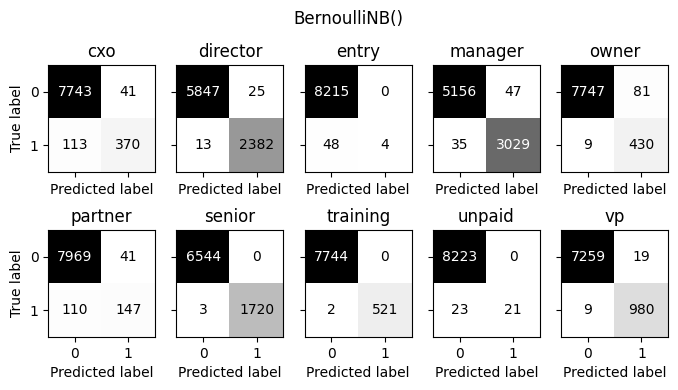

In [69]:
# Konfuzija naivnog Bajesa nad vrećom reči
konfuzija(bnb_bow, X_test_bow, y_test_bin)

Na primeru logističke regresije nad vrećom reči, suštinski nema uočljivih problema. Štaviše, klasifikacija početničkih (*entry*) pozicija je savršena.

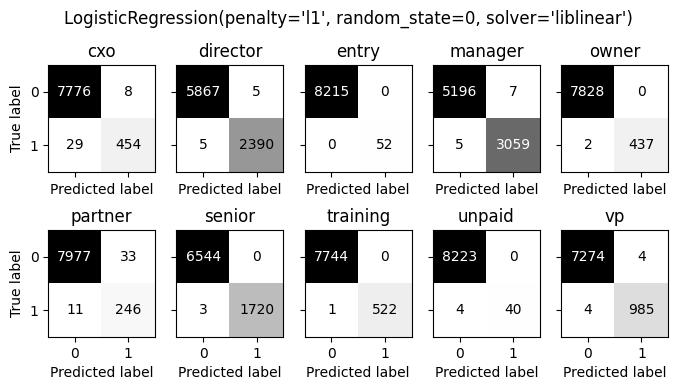

In [70]:
# Konfuzija logističke regresije nad vrećom reči
konfuzija(lr_bow, X_test_bow, y_test_bin)

Metod potpornih vektora nad vrećom reči daje rezultate koje veoma liče na one logističke regresije, mada sa malo više grešaka na test skupu.

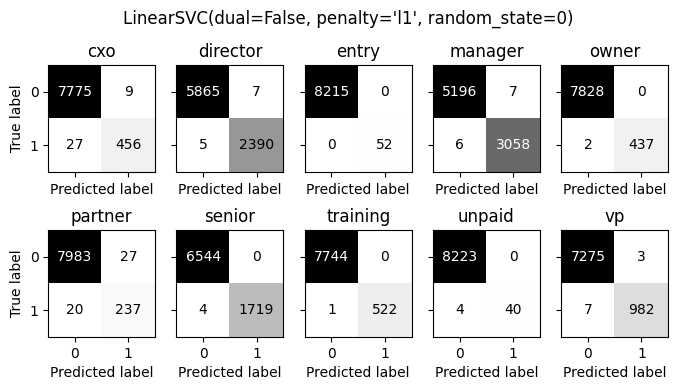

In [71]:
# Konfuzija potpornih vektora nad vrećom reči
konfuzija(lsvc_bow, X_test_bow, y_test_bin)

Čini se da algoritam najbližih suseda daje bolje rezultate od naivnog Bajesa, ali lošije od logističke regresije i metoda potpornih vektora.

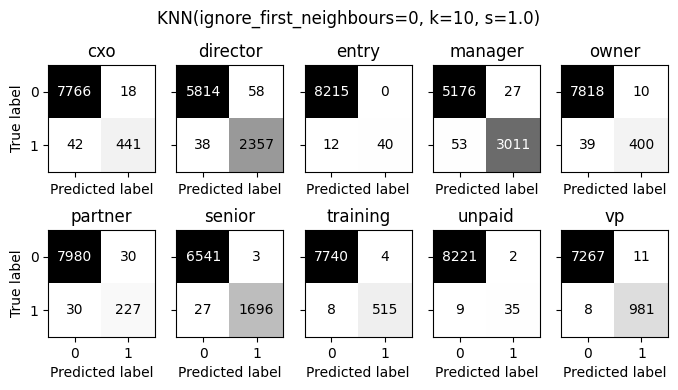

In [72]:
# Konfuzija najbližih suseda nad vrećom reči
konfuzija(knn_bow, X_test_bow, y_test_bin)

### 4.2 Mere uspešnosti [⮭]<a id="par:mere"></a>

[⮭]: #par:rezul

Iz matrica konfuzije moguće je izvesti mnogobrojne mere uspešnosti klasifikacije. U slučaju višelabelarne klasifikacije, mogu se uprosečiti. Najvažnije su:

$$ ACC = \frac{TP + TN}{TP + TN + FP + FN} \; \; — \; \text{tačnost,} $$

$$ TPR = \frac{TP}{TP + FN} \; \; — \; \text{odziv, osetljivost,} $$

$$ TNR = \frac{TN}{TN + FP} \; \; — \; \text{specifičnost, selektivnost,} $$

$$ PPV = \frac{TP}{TP + FP} \; \; — \; \text{preciznost, prediktivna vrednost,} $$

$$ F_1 = \frac{2}{\frac{1}{TPR} + \frac{1}{PPV}} = 2 \frac{TPR \cdot PPV}{TPR + PPV} = \frac{2TP}{2TP + FP + FN} \; \; — \; \text{F$_1$ mera.} $$

Teorijski savršena klasifikacija maksimizuje sve nabrojane mere, što u praksi uglavnom nije moguće. Uglavnom postoje (nedisjunktne) nagodbe imeđu [prediktivnih vrednosti](https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values), [odziva i preciznosti](https://en.wikipedia.org/wiki/Precision_and_recall), kao i [osetljivosti i specifičnosti](https://en.wikipedia.org/wiki/Sensitivity_and_specificity). Zanimljiv je i odnos [tačnosti i preciznosti](https://en.wikipedia.org/wiki/Accuracy_and_precision). Mera [$F_1$](https://en.wikipedia.org/wiki/F-score) u neku ruku pomiruje odziv i preciznost, budući njihova harmonijska sredina. Nešto naprednija statistički zasnovana mera uspešnosti jeste površina (*AUC*) ispod [*ROC*](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) krive. Sve nabrojane mere mogu se lepo predstaviti tabelarno, a u tome može pomoći modul [`pandas`](https://pandas.pydata.org/), koji omogućava komforan rad sa lepo stilizovanim *HTML* tabelama.

In [73]:
# Modul za rad sa lepim tabelama
import pandas as pd

# Modul za površinu ispod ROC krive
from sklearn.metrics import roc_auc_score

# Procentualni prikaz svih realnih brojeva
pd.set_option('display.float_format', '{:.2%}'.format)

# Funkcija za izračunavanje metrika
def metrike(model, X_test, y_true):
    # Predviđanje oznaka na skupu za proveru
    y_pred = model.predict(X_test)
    
    # Izračunavanje binarnih matrica konfuzije
    matrice = multilabel_confusion_matrix(y_true, y_pred)
    
    # Određivanje elemenata matrica konfuzije
    tn, tp = matrice[:, 0, 0], matrice[:, 1, 1]
    fn, fp = matrice[:, 1, 0], matrice[:, 0, 1]
    
    # Prazna tabela sa odgovarajućim indeksima
    tabela = pd.DataFrame(index=mlb.classes_)
    
    # Određivanje mera prema matrici konfuzije
    tabela['$ACC$'] = (tp + tn) / (tp + tn + fp + fn)
    tabela['$TPR$'] = tp / (tp + fn)
    tabela['$TNR$'] = tn / (tn + fp)
    tabela['$PPV$'] = tp / (tp + fp)
    tabela['$F_1$'] = 2*tp / (2*tp + fp + fn)
    
    # Predviđanje skorova na skupu za proveru
    try:
        y_score = np.transpose([prob[:, 1] for prob
              in model.predict_proba(X_test)])
    except:
        y_score = y_pred
    
    # Određivanje površine ispod ROC krive
    tabela['$AUC$'] = roc_auc_score(y_true, y_score, average=None)
    
    # Izračuvanje proseka svih mera
    tabela.loc[''] = tabela.mean()
    
    # Prikaz izračunate tabele
    display(tabela.T)

Na primeru naivnog Bajesa nad vrećom reči, može se još jednom uočiti problem sa odzivom početničkih, neplaćenih i partnerskih pozicija.

In [74]:
# Metrike naivnog Bajesa nad vrećom reči
metrike(bnb_bow, X_test_bow, y_test_bin)

,cxo,director,entry,manager,owner,partner,senior,training,unpaid,vp,
$ACC$,98.14%,99.54%,99.42%,99.01%,98.91%,98.17%,99.96%,99.98%,99.72%,99.66%,99.25%
$TPR$,76.60%,99.46%,7.69%,98.86%,97.95%,57.20%,99.83%,99.62%,47.73%,99.09%,78.40%
$TNR$,99.47%,99.57%,100.00%,99.10%,98.97%,99.49%,100.00%,100.00%,100.00%,99.74%,99.63%
$PPV$,90.02%,98.96%,100.00%,98.47%,84.15%,78.19%,100.00%,100.00%,100.00%,98.10%,94.79%
$F_1$,82.77%,99.21%,14.29%,98.66%,90.53%,66.07%,99.91%,99.81%,64.62%,98.59%,81.45%
$AUC$,97.43%,99.94%,99.99%,99.85%,99.90%,99.26%,99.95%,100.00%,99.01%,99.95%,99.53%


Na primeru logističke regresije nad vrećom reči, još jednom se može primetiti odličan uspeh. Najniža je preciznost kod partnerskih pozicija.

In [75]:
# Metrike logističke regresije nad vrećom reči
metrike(lr_bow, X_test_bow, y_test_bin)

,cxo,director,entry,manager,owner,partner,senior,training,unpaid,vp,
$ACC$,99.55%,99.88%,100.00%,99.85%,99.98%,99.47%,99.96%,99.99%,99.95%,99.90%,99.85%
$TPR$,94.00%,99.79%,100.00%,99.84%,99.54%,95.72%,99.83%,99.81%,90.91%,99.60%,97.90%
$TNR$,99.90%,99.91%,100.00%,99.87%,100.00%,99.59%,100.00%,100.00%,100.00%,99.95%,99.92%
$PPV$,98.27%,99.79%,100.00%,99.77%,100.00%,88.17%,100.00%,100.00%,100.00%,99.60%,98.56%
$F_1$,96.08%,99.79%,100.00%,99.80%,99.77%,91.79%,99.91%,99.90%,95.24%,99.60%,98.19%
$AUC$,99.11%,99.93%,100.00%,99.97%,99.91%,99.92%,99.92%,100.00%,98.08%,99.89%,99.67%


U slučaju metoda potpornih vektora nad vrećom reči, i ovog puta su komentari identični onima kod logističke regresije.

In [76]:
# Metrike potpornih vektora nad vrećom reči
metrike(lsvc_bow, X_test_bow, y_test_bin)

,cxo,director,entry,manager,owner,partner,senior,training,unpaid,vp,
$ACC$,99.56%,99.85%,100.00%,99.84%,99.98%,99.43%,99.95%,99.99%,99.95%,99.88%,99.84%
$TPR$,94.41%,99.79%,100.00%,99.80%,99.54%,92.22%,99.77%,99.81%,90.91%,99.29%,97.55%
$TNR$,99.88%,99.88%,100.00%,99.87%,100.00%,99.66%,100.00%,100.00%,100.00%,99.96%,99.93%
$PPV$,98.06%,99.71%,100.00%,99.77%,100.00%,89.77%,100.00%,100.00%,100.00%,99.70%,98.70%
$F_1$,96.20%,99.75%,100.00%,99.79%,99.77%,90.98%,99.88%,99.90%,95.24%,99.49%,98.10%
$AUC$,97.15%,99.84%,100.00%,99.83%,99.77%,95.94%,99.88%,99.90%,95.45%,99.63%,98.74%


Kod algoritma najbližih suseda primetan je nešto manji odziv kod početničkih (*entry*) i neplaćenih (*unpaid*) pozicija.

In [77]:
# Metrike najbližih suseda nad vrećom reči
metrike(knn_bow, X_test_bow, y_test_bin)

,cxo,director,entry,manager,owner,partner,senior,training,unpaid,vp,
$ACC$,99.27%,98.84%,99.85%,99.03%,99.41%,99.27%,99.64%,99.85%,99.87%,99.77%,99.48%
$TPR$,91.30%,98.41%,76.92%,98.27%,91.12%,88.33%,98.43%,98.47%,79.55%,99.19%,92.00%
$TNR$,99.77%,99.01%,100.00%,99.48%,99.87%,99.63%,99.95%,99.95%,99.98%,99.85%,99.75%
$PPV$,96.08%,97.60%,100.00%,99.11%,97.56%,88.33%,99.82%,99.23%,94.59%,98.89%,97.12%
$F_1$,93.63%,98.00%,86.96%,98.69%,94.23%,88.33%,99.12%,98.85%,86.42%,99.04%,94.33%
$AUC$,97.25%,99.78%,95.03%,99.70%,98.75%,98.43%,99.91%,99.79%,92.99%,99.86%,98.15%


### 4.3 Skor klasifikatora [⮭]<a id="par:skor"></a>

[⮭]: #par:rezul

Tačnost je mera koja je primenljiva i u širem planu, kao udeo instanci kojima je korektno predviđen ceo vektor senioriteta. U tom obliku, naziva se skorom klasifikatora i nešto je pesimističnija mera u odnosu na uprosečenu tačnost na svim klasama. Ipak, razlika u rezultatima maltene je zanemarljiva.

In [78]:
# Ispis skora modela na skupu za proveru
def skor(model, X_test, y_test):
    print('Udeo tačnih predviđanja:',
          '{:.2%}'.format(model.score(X_test, y_test)))

In [79]:
# Sveukupni skor naivnog Bajesa nad vrećom reči
skor(bnb_bow, X_test_bow, y_test_bin)

Udeo tačnih predviđanja: 93.01%


In [80]:
# Sveukupni skor logističke regresije nad vrećom reči
skor(lr_bow, X_test_bow, y_test_bin)

Udeo tačnih predviđanja: 98.61%


In [81]:
# Sveukupni skor potpornih vektora nad vrećom reči
skor(lsvc_bow, X_test_bow, y_test_bin)

Udeo tačnih predviđanja: 98.51%


In [82]:
# Sveukupni skor najbližih suseda nad vrećom reči
skor(knn_bow, X_test_bow, y_test_bin)

Udeo tačnih predviđanja: 95.22%
